In [17]:
import pandas as pd
import os
import sys
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, filter_counties
from scripts.utils.write_metadata import append_metadata

In [2]:
# pull .xlsx from aws
impervious_link = 's3://ca-climate-index/2b_reproject/natural_systems/ecosystem_condition/usgs/ca_reprojected_clipped_impervious_surfaces.zarr/'

In [4]:
ds_zarr = xr.open_zarr(impervious_link)

In [6]:
print(ds_zarr)


<xarray.Dataset>
Dimensions:                        (band: 1, y: 29588, x: 32304)
Coordinates:
  * band                           (band) int32 1
  * x                              (x) float64 -124.5 -124.5 ... -114.1 -114.1
  * y                              (y) float64 42.01 42.01 42.01 ... 32.53 32.53
Data variables:
    __xarray_dataarray_variable__  (band, y, x) float64 dask.array<chunksize=(1, 11585, 11585), meta=np.ndarray>
    spatial_ref                    int32 ...


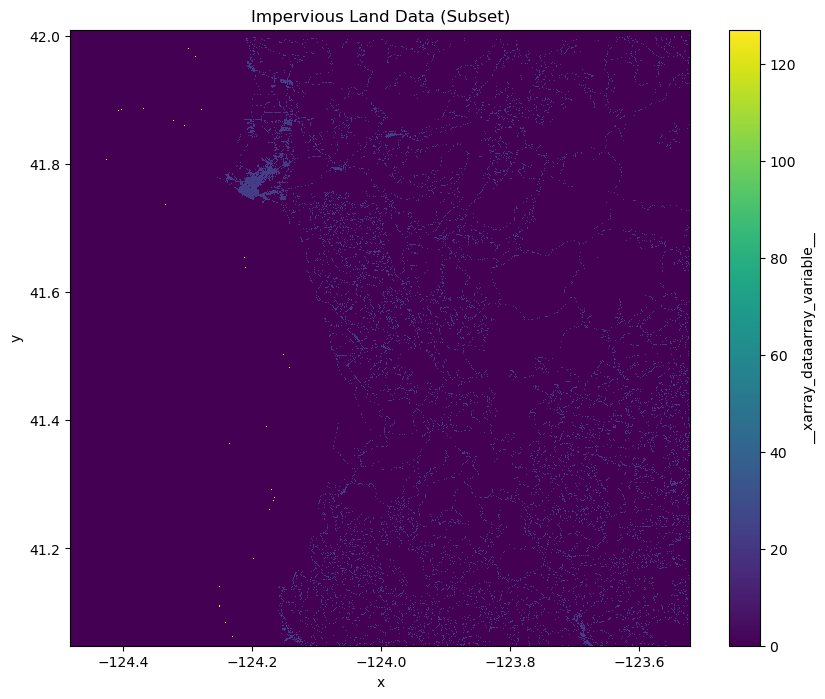

In [13]:
# Select a small subset of data for quick visualization
data_var_subset = ds_zarr['__xarray_dataarray_variable__'].isel(x=slice(0, 3000), y=slice(0, 3000))

# Plot the subset
plt.figure(figsize=(10, 8))
data_var_subset.plot()
plt.title('Impervious Land Data (Subset)')
plt.show()

In [15]:
# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)

In [23]:
# Convert DataArray to DataFrame
df = data_var_subset.to_dataframe().reset_index()

In [24]:
# Create geometry column from coordinates
geometry = [Point(xy) for xy in zip(df['x'], df['y'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

In [35]:
gdf.set_crs(epsg=4326, inplace=True)

,band,y,x,__xarray_dataarray_variable__,geometry
0,1,42.009354,-124.481939,0.0,POINT (-124.48194 42.00935)
1,1,42.009354,-124.481618,0.0,POINT (-124.48162 42.00935)
2,1,42.009354,-124.481298,0.0,POINT (-124.48130 42.00935)
3,1,42.009354,-124.480978,0.0,POINT (-124.48098 42.00935)
4,1,42.009354,-124.480657,0.0,POINT (-124.48066 42.00935)
...,...,...,...,...,...
8999995,1,41.048383,-123.522249,0.0,POINT (-123.52225 41.04838)
8999996,1,41.048383,-123.521929,0.0,POINT (-123.52193 41.04838)
8999997,1,41.048383,-123.521608,0.0,POINT (-123.52161 41.04838)
8999998,1,41.048383,-123.521288,0.0,POINT (-123.52129 41.04838)


In [27]:
# Check the current CRS of the GeoDataFrame
print("gdf CRS:", gdf.crs)

# Load your California boundaries GeoDataFrame (ca_boundaries)
# ca_boundaries = gpd.read_file('path_to_ca_boundaries_file')

# Check the current CRS of the California boundaries GeoDataFrame
print("ca_boundaries CRS:", ca_boundaries.crs)

# If they have different CRS, transform one to match the other
# For example, if you want to transform gdf to match ca_boundaries' CRS
if gdf.crs != ca_boundaries.crs:
    ca_boundaries = ca_boundaries.to_crs(gdf.crs)

# Now both GeoDataFrames should have the same CRS
print("Transformed gdf CRS:", gdf.crs)

gdf CRS: EPSG:4326
ca_boundaries CRS: EPSG:4269
Transformed gdf CRS: EPSG:4326


In [33]:
gdf.__xarray_dataarray_variable__.mean()

0.7850805555555556

In [36]:
# Perform the spatial join
merged_gdf = gpd.sjoin(gdf, ca_boundaries, how='inner', op='intersects')

# Verify the merged GeoDataFrame
print(merged_gdf.head())

c:\Users\jespi\miniconda3\envs\carb\lib\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


       band          y           x  __xarray_dataarray_variable__  \
83864     1  42.000703 -123.564226                            0.0   
83865     1  42.000703 -123.563905                            0.0   
83866     1  42.000703 -123.563585                            0.0   
83867     1  42.000703 -123.563264                            0.0   
83868     1  42.000703 -123.562944                            0.0   

                          geometry  index_right STATEFP COUNTYFP TRACTCE  \
83864  POINT (-123.56423 42.00070)         4802      06      015  000202   
83865  POINT (-123.56391 42.00070)         4802      06      015  000202   
83866  POINT (-123.56358 42.00070)         4802      06      015  000202   
83867  POINT (-123.56326 42.00070)         4802      06      015  000202   
83868  POINT (-123.56294 42.00070)         4802      06      015  000202   

             GEOID  NAME           NAMELSAD  MTFCC FUNCSTAT       ALAND  \
83864  06015000202  2.02  Census Tract 2.02  G5020   

In [46]:
merged_gdf

,band,y,x,__xarray_dataarray_variable__,geometry,index_right,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
83864,1,42.000703,-123.564226,0.0,POINT (-123.56423 42.00070),4802,06,015,000202,06015000202,2.02,Census Tract 2.02,G5020,S,2083657688,12922708,+41.7468282,-123.8637597
83865,1,42.000703,-123.563905,0.0,POINT (-123.56391 42.00070),4802,06,015,000202,06015000202,2.02,Census Tract 2.02,G5020,S,2083657688,12922708,+41.7468282,-123.8637597
83866,1,42.000703,-123.563585,0.0,POINT (-123.56358 42.00070),4802,06,015,000202,06015000202,2.02,Census Tract 2.02,G5020,S,2083657688,12922708,+41.7468282,-123.8637597
83867,1,42.000703,-123.563264,0.0,POINT (-123.56326 42.00070),4802,06,015,000202,06015000202,2.02,Census Tract 2.02,G5020,S,2083657688,12922708,+41.7468282,-123.8637597
83868,1,42.000703,-123.562944,0.0,POINT (-123.56294 42.00070),4802,06,015,000202,06015000202,2.02,Census Tract 2.02,G5020,S,2083657688,12922708,+41.7468282,-123.8637597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999137,1,41.048383,-123.797179,0.0,POINT (-123.79718 41.04838),8971,06,023,010300,06023010300,103,Census Tract 103,G5020,S,648595079,1138861,+40.9265216,-123.8880328
8999138,1,41.048383,-123.796858,0.0,POINT (-123.79686 41.04838),8971,06,023,010300,06023010300,103,Census Tract 103,G5020,S,648595079,1138861,+40.9265216,-123.8880328
8999139,1,41.048383,-123.796538,0.0,POINT (-123.79654 41.04838),8971,06,023,010300,06023010300,103,Census Tract 103,G5020,S,648595079,1138861,+40.9265216,-123.8880328
8999140,1,41.048383,-123.796217,0.0,POINT (-123.79622 41.04838),8971,06,023,010300,06023010300,103,Census Tract 103,G5020,S,648595079,1138861,+40.9265216,-123.8880328


In [41]:
print("Total bounds of bbox_gdf:", bbox_gdf.total_bounds)
print("Are all geometries valid?", bbox_gdf.is_valid.all())
print("Total bounds of merged_gdf:", merged_gdf.total_bounds)


Total bounds of bbox_gdf: [nan nan nan nan]
Are all geometries valid? True
Total bounds of merged_gdf: [-124.44060334   41.0483829  -123.52096743   42.00070274]


In [42]:
# Define your bounding box (xmin, ymin, xmax, ymax)
bbox = (-120, 35, -118, 37)

# Check that the bbox values are within the extent of the data
print("Bounding box:", bbox)
print("Extent of merged_gdf:", merged_gdf.total_bounds)

# Filter the GeoDataFrame
bbox_gdf = merged_gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]


Bounding box: (-120, 35, -118, 37)
Extent of merged_gdf: [-124.44060334   41.0483829  -123.52096743   42.00070274]


In [43]:
# Filter using the bounding box
bbox_gdf = merged_gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

In [45]:
# Check total bounds and data
print("Total bounds of merged_gdf:", merged_gdf.total_bounds)
print("Bounding box:", bbox)

# Filter data
bbox_gdf = merged_gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# Check if the filtered GeoDataFrame is empty or has valid geometries
print("Filtered bbox_gdf empty?", bbox_gdf.empty)
print("First few rows of bbox_gdf:", bbox_gdf.head() if not bbox_gdf.empty else "No data")
print("Total bounds of bbox_gdf:", bbox_gdf.total_bounds if not bbox_gdf.empty else "No data")

Total bounds of merged_gdf: [-124.44060334   41.0483829  -123.52096743   42.00070274]
Bounding box: (-120, 35, -118, 37)
Filtered bbox_gdf empty? True
First few rows of bbox_gdf: No data
Total bounds of bbox_gdf: No data


ValueError: aspect must be finite and positive 

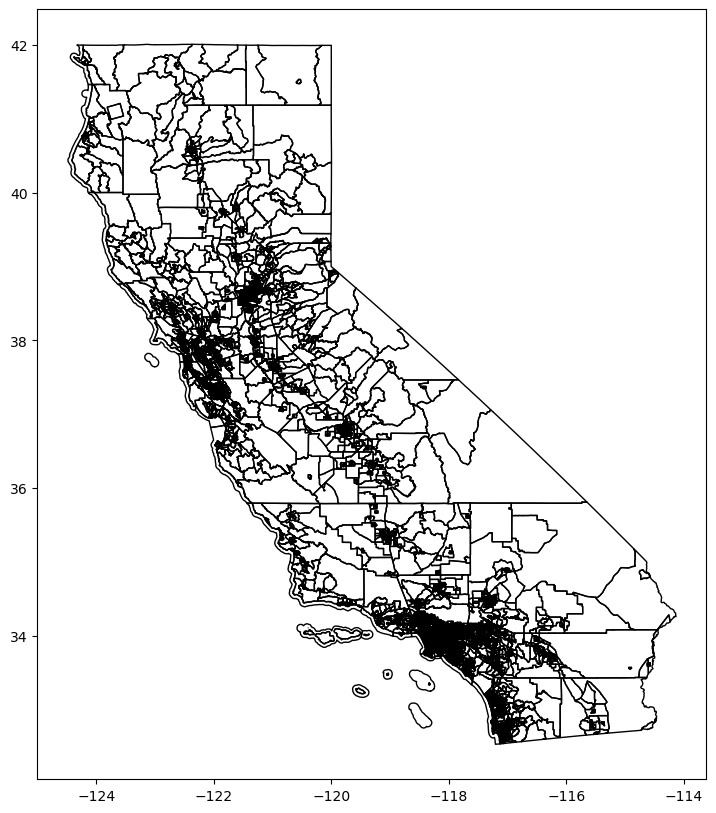

In [44]:
# Create a plot with the filtered data
fig, ax = plt.subplots(figsize=(10, 10))

# Plot California boundaries for reference
ca_boundaries.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label='California Boundaries')

# Plot the filtered GeoDataFrame
bbox_gdf.plot(ax=ax, column='__xarray_dataarray_variable__', cmap='viridis', legend=True, label='Impervious Land Data')

# Customize plot
plt.title('Filtered Impervious Land Data with California Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()


C:\Users\jespi\AppData\Local\Temp\ipykernel_22040\3572779474.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


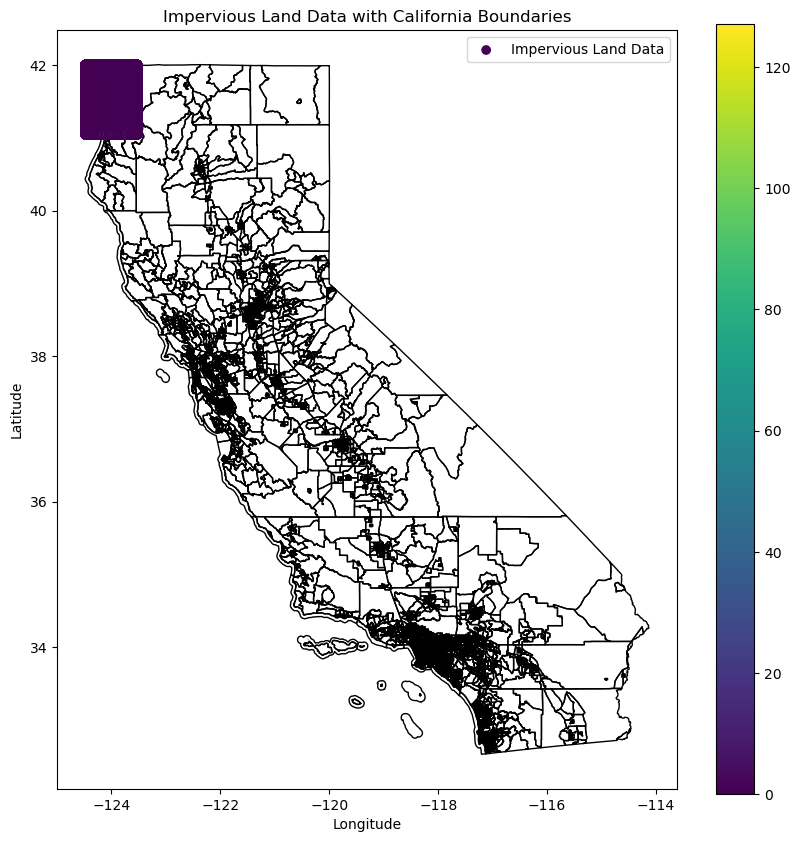

In [28]:
# Plotting both GeoDataFrames
fig, ax = plt.subplots(figsize=(10, 10))

# Plot California boundaries
ca_boundaries.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label='California Boundaries')

# Plot the impervious land data
gdf.plot(ax=ax, column='__xarray_dataarray_variable__', cmap='viridis', legend=True, label='Impervious Land Data')

# Customize plot
plt.title('Impervious Land Data with California Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()